In [1]:
import matplotlib.image as mpimg
import scipy.misc as spmisc
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
# NOTE: the next import is only valid
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

from scipy.ndimage.measurements import label

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
%matplotlib inline

# Load Data

In [3]:
def show_images(images, labels_true, rows, cols, cls=None, random=True, labels_predicted=None):
    fig, axes = plt.subplots(rows, cols)
    fig.subplots_adjust(hspace=0.37, wspace=0.3)
    imidx = 0
    for i, ax in enumerate(axes.flat):
        while True:
            if random:
                example = np.random.randint(0, len(images))
            else:
                example = imidx
                imidx += 1
            if cls is None or labels_true[example]==cls:
                break
        if example >= len(images):
            return
        if len(images.shape)==4:
            ax.imshow(images[example,:,:,:]);
        else:
            ax.imshow(images[example,:,:], cmap='Greys_r');
        ax.set_xticks([])
        ax.set_yticks([])
        if labels_predicted is not None:
            str = '{}: true {} pred {}'.format(example, labels_true[example], labels_predicted[example])
        else:
            str = '{}: true {}'.format(example, labels_true[example])
        ax.set_xlabel(str)

In [4]:
default_color_space = 'RGB'
def read_image(file):
    return spmisc.imread(file, mode=default_color_space)

In [5]:
def read_image_data(path):
    files = glob.glob(path)
    images = np.array([read_image(f) for f in files])
    return files, images

In [6]:
# Read in vehicles data
car_files, car_images = read_image_data('data/vehicles/*/*.*')

print('number of car files: {}'.format(len(car_files)))
print('unique file extensions: {}'.format(np.unique([c[c.rfind('.'):] for c in car_files])))
print('car images array shape: {}'.format(car_images.shape))

number of car files: 8792
unique file extensions: ['.png']
car images array shape: (8792, 64, 64, 3)


In [7]:
# Read in NON-vehicles data
noncar_files, noncar_images = read_image_data('data/non-vehicles/*/*.*')

print('number of non-car files: {}'.format(len(noncar_files)))
print('unique file extensions: {}'.format(np.unique([c[c.rfind('.'):] for c in noncar_files])))
print('non-car images array shape: {}'.format(noncar_images.shape))

number of non-car files: 8968
unique file extensions: ['.png']
non-car images array shape: (8968, 64, 64, 3)


In [8]:
# combine data. the classes are quite balanced
allimages = np.vstack([car_images, noncar_images])
alllabels = np.hstack([np.ones(len(car_images)), np.zeros(len(noncar_images))]).astype(np.uint8)

In [9]:
allimages.shape

(17760, 64, 64, 3)

In [10]:
alllabels.shape

(17760,)

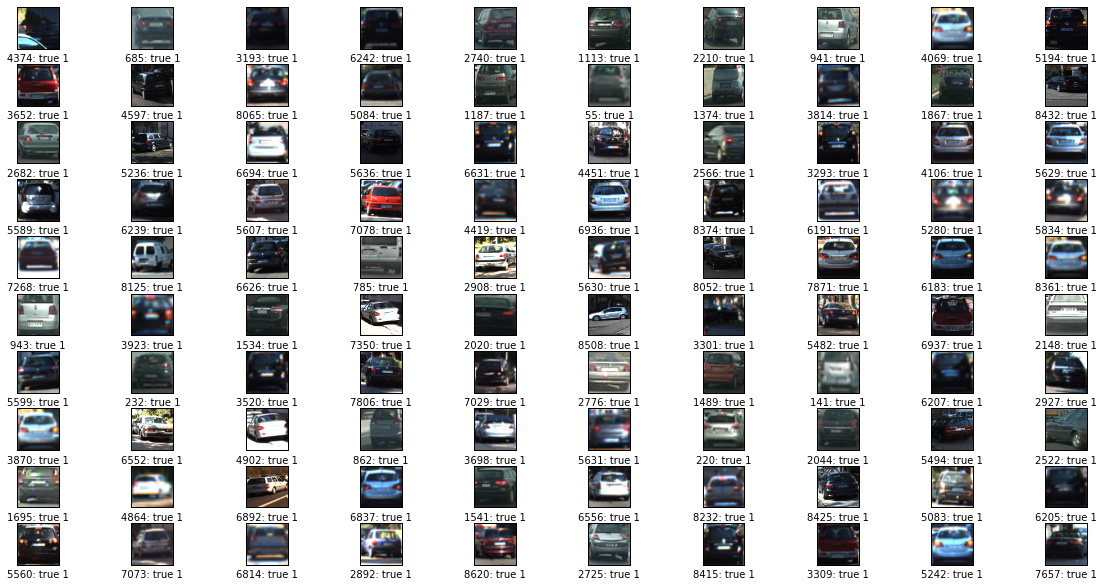

In [11]:
# cars
show_images(allimages, alllabels, 10, 10, cls=1)

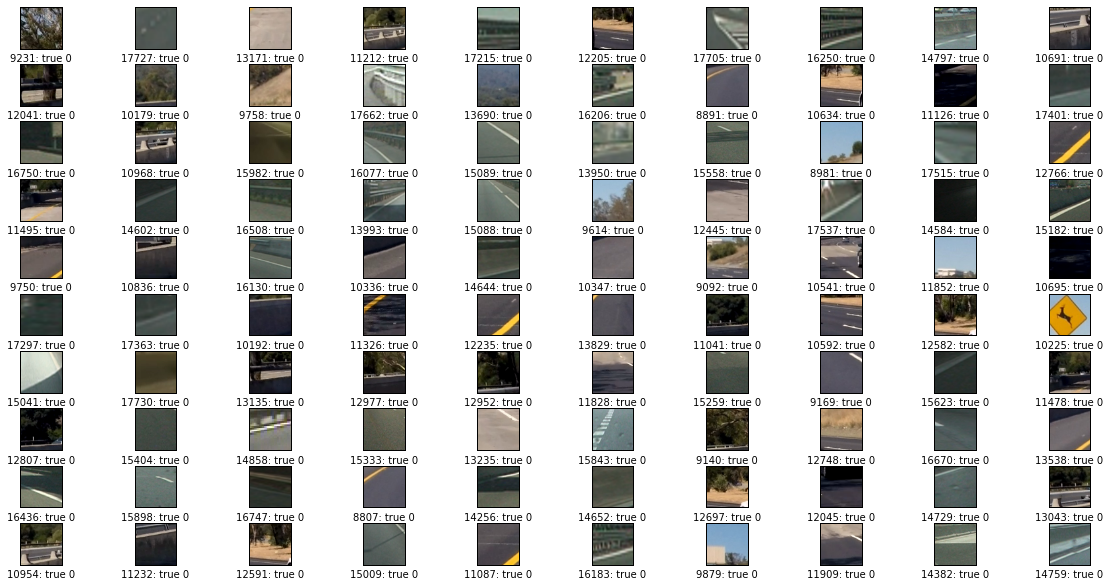

In [12]:
# NON-cars
show_images(allimages, alllabels, 10, 10, cls=0)

# test images

In [13]:
image = read_image('test_images/test5.jpg')
image.shape

(720, 1280, 3)

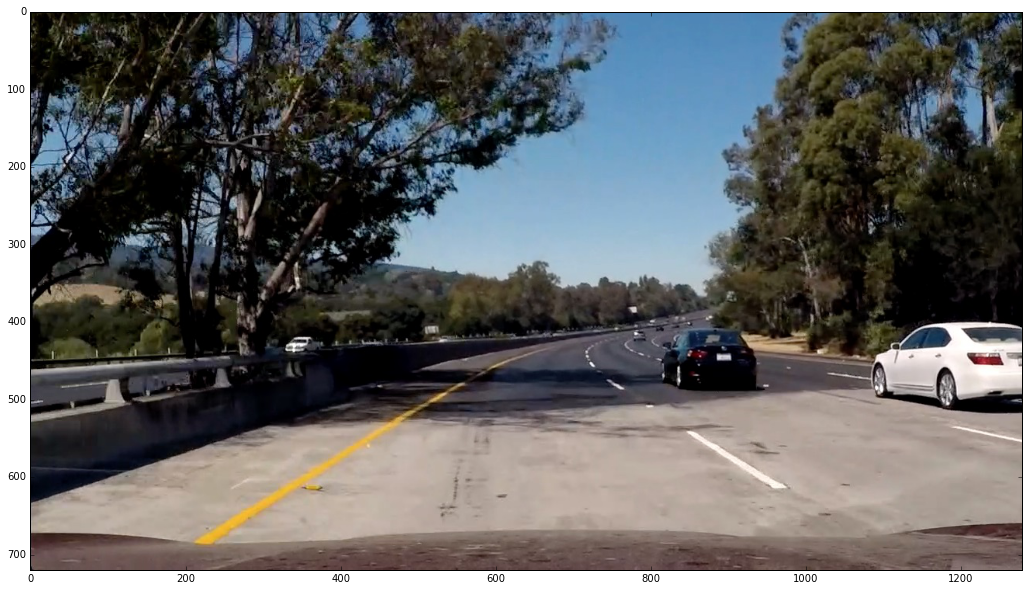

In [14]:
plt.imshow(image);

In [15]:
carimage = car_images[100]

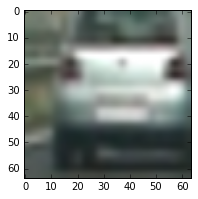

In [16]:
plt.figure(figsize=(3,3))
plt.imshow(carimage);

# define features

## spatial features

In [17]:
def convert_color(img, from_colorspace=default_color_space, to_colorspace=default_color_space):
    if (from_colorspace==to_colorspace):
        tmpimg = img
    else:
        convstr = 'cv2.COLOR_'+from_colorspace+'2'+to_colorspace
        cv2color = eval(convstr)
        tmpimg = cv2.cvtColor(img, cv2color)
    return tmpimg

In [18]:
def image_resize(img, size):
    small_img = cv2.resize(img, size)
    return small_img

In [19]:
# compute spatial features (essentially image pixels)
# Pass the color_space flag as 3-letter all caps string like 'HSV' or 'LUV' etc.    
def features_spatial(img, size=(32, 32), feature_vec=True):
    small_img = image_resize(img, size)
    if feature_vec:
        features = small_img.ravel()
    else:
        features = small_img
    return features

In [ ]:
small_image_size = (32,32)
spatial_colorspace='HLS'
feature_vec=True

In [ ]:
tmpimg = convert_color(carimage, to_colorspace=spatial_colorspace)
feature_vec = features_spatial(carimage, size=small_image_size, feature_vec=feature_vec)
feature_vec.shape

In [ ]:
feature_vec

In [ ]:
plt.plot(feature_vec)
plt.title('Spatially Binned Features');

## color histogram features

In [20]:
# compute color histogram features  
def features_color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    return hist_features, bin_centers

In [ ]:
num_color_bins = 32
color_bins_range = (0,256)

In [ ]:
feature_vec, bin_centers = features_color_hist(carimage, nbins=num_color_bins, bins_range=color_bins_range)
feature_vec.shape

In [ ]:
plt.plot(feature_vec)
plt.title('Color Histogram Features');

In [ ]:
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, feature_vec[0*len(bin_centers):1*len(bin_centers)])
plt.xlim(0, 256)
plt.title('Channel 1 Histogram')
plt.subplot(132)
plt.bar(bin_centers, feature_vec[1*len(bin_centers):2*len(bin_centers)])
plt.xlim(0, 256)
plt.title('Channel 2 Histogram')
plt.subplot(133)
plt.bar(bin_centers, feature_vec[2*len(bin_centers):3*len(bin_centers)])
plt.xlim(0, 256)
plt.title('Channel 3 Histogram')
fig.tight_layout()

In [ ]:
hls_carimage = convert_color(carimage, 'HLS')

In [ ]:
feature_vec, bin_centers = features_color_hist(hls_carimage, nbins=num_color_bins, bins_range=color_bins_range)

In [ ]:
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, feature_vec[0*len(bin_centers):1*len(bin_centers)])
plt.xlim(0, 256)
plt.title('Channel 1 Histogram')
plt.subplot(132)
plt.bar(bin_centers, feature_vec[1*len(bin_centers):2*len(bin_centers)])
plt.xlim(0, 256)
plt.title('Channel 2 Histogram')
plt.subplot(133)
plt.bar(bin_centers, feature_vec[2*len(bin_centers):3*len(bin_centers)])
plt.xlim(0, 256)
plt.title('Channel 3 Histogram')
fig.tight_layout()

## HOG features

In [21]:
# HOG features and (optionally) visualization
def features_hog(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # skimage.hog()
    r = hog(img,
            orientations = orient,
            pixels_per_cell = (pix_per_cell,pix_per_cell),
            cells_per_block = (cell_per_block,cell_per_block),
            visualise = vis,
            transform_sqrt=True, # gamma correction
            feature_vector = feature_vec)
    if vis == True:
        features, hog_image = r
        return features, hog_image
    else:      
        features = r
        return features

In [ ]:
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

In [ ]:
gray_image = cv2.cvtColor(carimage, cv2.COLOR_RGB2GRAY)

In [ ]:
%time hog_features, hog_image = features_hog(gray_image, orient, pix_per_cell, cell_per_block, \
                                           vis=True, feature_vec=True)

In [ ]:
hog_features.shape

In [ ]:
hog_features

In [ ]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(gray_image, cmap='gray')
plt.title('Example Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization');

In [ ]:
# convert to gray
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# only use lower half of the image
h, w = gray_image.shape
gray_image = gray_image[h//2:, :]

In [ ]:
%time hog_features, hog_image = features_hog(gray_image, orient, pix_per_cell, cell_per_block, \
                                           vis=True, feature_vec=False)

In [ ]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(gray_image, cmap='gray')
plt.title('Example Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization');

## combine and normalise features

In [22]:
def extract_features(images, 
                     to_colorspace='RGB', 
                     spatial_size=(32, 32),
                     hist_bins=32, 
                     hist_range=(0, 256),
                     hog_orient=9,
                     hog_pix_per_cell=8, 
                     hog_cell_per_block=2, 
                     hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in images:
        tmpimg = convert_color(img, to_colorspace=to_colorspace)
        
        spfeat = features_spatial(tmpimg, spatial_size, feature_vec=True)

        hfeat, bin_centers = features_color_hist(tmpimg, hist_bins, hist_range)
                
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hogfeat = []
            for channel in range(tmpimg.shape[2]):
                hogfeat.append(features_hog(tmpimg[:,:,channel], 
                                                   hog_orient, 
                                                   hog_pix_per_cell, 
                                                   hog_cell_per_block, 
                                                   vis=False, 
                                                   feature_vec=True))
            hogfeat = np.ravel(hogfeat)        
        else:
            hogfeat = features_hog(tmpimg[:,:,hog_channel], 
                                   hog_orient, 
                                   hog_pix_per_cell, 
                                   hog_cell_per_block, 
                                   vis=False, 
                                   feature_vec=True)        
        
        features.append(np.concatenate((spfeat, hfeat, hogfeat)))
    return features

In [23]:
colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (32, 32)
hist_bins = 32
hist_range = (0, 256)
hog_orient = 9
hog_pix_per_cell = 8
hog_cell_per_block = 2
hog_channel = 1 # Can be 0, 1, 2, or "ALL"

In [24]:
allfeatures = extract_features(allimages, 
                                 to_colorspace=colorspace, 
                                 spatial_size=spatial_size,
                                 hist_bins=hist_bins, 
                                 hist_range=hist_range,
                                 hog_orient=hog_orient,
                                 hog_pix_per_cell=hog_pix_per_cell, 
                                 hog_cell_per_block=hog_cell_per_block, 
                                 hog_channel=hog_channel)

In [25]:
# scaler expects float64
allfeatures = np.array(allfeatures).astype(np.float64)

In [26]:
allimages.shape

(17760, 64, 64, 3)

In [27]:
allfeatures.shape

(17760, 4932)

In [28]:
feature_scaler = StandardScaler().fit(allfeatures)
scaled_features = feature_scaler.transform(allfeatures)

In [ ]:
car_ind = np.random.randint(0, len(car_images))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(car_images[car_ind])
plt.title('Original Image')
plt.subplot(132)
plt.plot(allfeatures[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_features[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

## train classifier

In [29]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_features, alllabels, test_size=0.2, random_state=rand_state)

In [30]:
print('Colorspace: '+colorspace)
print('Spatial binning size: {}'.format(spatial_size))
print('Color histogram bins: {}'.format(hist_bins))
print('Color histogram range: {}'.format(hist_range))
print('HOG orient: {}'.format(hog_orient))
print('HOG pix per cell: {}'.format(hog_pix_per_cell))
print('HOG cells per block: {}'.format(hog_cell_per_block))
print('HOG challen: {}'.format(hog_channel))
print('Feature vector length: {}'.format(len(X_train[0])))

classifier = LinearSVC()
#classifier = SVC(C=1.0, kernel='linear')
%time classifier.fit(X_train, y_train)

Colorspace: HLS
Spatial binning size: (32, 32)
Color histogram bins: 32
Color histogram range: (0, 256)
HOG orient: 9
HOG pix per cell: 8
HOG cells per block: 2
HOG challen: 1
Feature vector length: 4932
CPU times: user 11.9 s, sys: 1.1 s, total: 13 s
Wall time: 13.6 s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [31]:
print('Test Accuracy of classifier = ', round(classifier.score(X_test, y_test), 4))

n_predict = 30
%time pred = classifier.predict(X_test[0:n_predict])
print('Predicted: {}'.format(pred               ))
print('Actual   : {}'.format(y_test[0:n_predict]))

n_predict = 1500
%time pred = classifier.predict(X_test[0:n_predict])


Test Accuracy of classifier =  0.9876
CPU times: user 2.24 ms, sys: 70 µs, total: 2.31 ms
Wall time: 327 µs
Predicted: [0 0 1 1 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 1 1]
Actual   : [0 0 1 1 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 1 1]
CPU times: user 25.8 ms, sys: 67 µs, total: 25.9 ms
Wall time: 6.09 ms


In [ ]:
n_predict=30
classifier.decision_function(X_test[0:n_predict])>0.6

## sliding windows

In [32]:
# draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [33]:
# Generate sliding windows coordinates.
# Takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, 
                 x_start_stop=[None, None], 
                 y_start_stop=[None, None],
                 window_size = (64, 64), 
                 window_overlap_fraction = (0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    h, w, _ = img.shape
    x_start = 0 if x_start_stop[0] is None else x_start_stop[0]
    y_start = 0 if y_start_stop[0] is None else y_start_stop[0]
    x_stop  = w if x_start_stop[1] is None else x_start_stop[1]
    y_stop  = h if y_start_stop[1] is None else y_start_stop[1]
    # Compute the span of the region to be searched
    x_span = x_stop - x_start
    y_span = y_stop - y_start
    # Compute the number of pixels per step in x/y
    x_step = int(float(window_size[0])*window_overlap_fraction[0])
    y_step = int(float(window_size[1])*window_overlap_fraction[1])
    # Compute the number of windows in x/y
    x_windows = x_span // x_step
    y_windows = y_span // y_step
    # make windows list
    window_list = []
    for x in range(x_start,x_stop,x_step):
        for y in range(y_start,y_stop,y_step):
            window = ((x,y),(x+window_size[0],y+window_size[1]))
            window_list.append(window)
    return window_list

In [ ]:
windows128 = slide_window(image, 
                       x_start_stop=[None, None], 
                       y_start_stop=[image.shape[0]//2+32, image.shape[0]//2+32+128],
                       window_size=(128, 128), 
                       window_overlap_fraction=(0.25, 0.25))
window_img = draw_boxes(image, windows128, color=(0, 0, 255), thick=3)
window_img = draw_boxes(window_img, (windows128[0],), color=(255, 0, 0), thick=6)
plt.imshow(window_img);
len(windows128)

In [ ]:
windows96 = slide_window(image, 
                       x_start_stop=[None, None], 
                       y_start_stop=[image.shape[0]//2+32, image.shape[0]//2+32+128+32],
                       window_size=(96, 96), 
                       window_overlap_fraction=(0.25, 0.25))
window_img = draw_boxes(image, windows96, color=(0, 0, 255), thick=3)
window_img = draw_boxes(window_img, (windows96[0],), color=(255, 0, 0), thick=6)
plt.imshow(window_img);
len(windows96)

In [ ]:
windows64 = slide_window(image, 
                       x_start_stop=[200, 1100], 
                       y_start_stop=[image.shape[0]//2+32, image.shape[0]//2+32+128],
                       window_size=(64, 64), 
                       window_overlap_fraction=(0.25, 0.25))
window_img = draw_boxes(image, windows64, color=(0, 0, 255), thick=3)
window_img = draw_boxes(window_img, (windows64[0],), color=(255, 0, 0), thick=6)
plt.imshow(window_img);
len(windows64)

In [ ]:
windows48 = slide_window(image, 
                       x_start_stop=[400, 1100], 
                       y_start_stop=[image.shape[0]//2+32, image.shape[0]//2+32+64],
                       window_size=(48, 48), 
                       window_overlap_fraction=(0.4, 0.4))
window_img = draw_boxes(image, windows48, color=(0, 0, 255), thick=3)
window_img = draw_boxes(window_img, (windows48[0],), color=(255, 0, 0), thick=6)
plt.imshow(window_img);
len(windows48)

In [ ]:
windows = windows128 + windows96 + windows64 + windows48

In [ ]:
len(windows)

## search and classify

In [34]:
# Predict for each window in the image.
# Extracts features at each window position, and predicts with classifier
def search_windows(img, 
                   windows, 
                   classifier, 
                   scaler, 
                   decision_function_threshold = 0.0,
                   classifier_input_size = (64, 64),
                   colorspace = 'RGB', 
                   spatial_size = (32, 32), 
                   hist_bins = 32, 
                   hist_range = (0, 256), 
                   hog_orient = 9, 
                   hog_pix_per_cell = 8, 
                   hog_cell_per_block = 2, 
                   hog_channel = 0):

    test_imgs = np.zeros((len(windows), classifier_input_size[0], classifier_input_size[1], 3), np.uint8)
    for i,window in enumerate(windows):
        # extract the test window from original image
        test_imgs[i,:,:,:] = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], classifier_input_size)

    # TODO: do HOG features for entire image. multiple scales?
    features = extract_features(images = test_imgs, 
                                to_colorspace = colorspace, 
                                spatial_size = spatial_size,
                                hist_bins = hist_bins, 
                                hist_range = hist_range,
                                hog_orient = hog_orient,
                                hog_pix_per_cell = hog_pix_per_cell, 
                                hog_cell_per_block = hog_cell_per_block, 
                                hog_channel = hog_channel)
    features = np.array(features).astype(np.float64)
    scaled_features = scaler.transform(features)

    pred2 = classifier.predict(scaled_features)
    #pred = classifier.decision_function(scaled_features)>decision_function_threshold
    #pred2 = np.zeros_like(pred)
    #pred2[pred] = 1
    
    # positive detection windows
    on_windows = [windows[i] for i,p in enumerate(pred2) if p==1]
    
    return on_windows

In [35]:
classifier_input_size = carimage.shape[0:2]

In [ ]:
%time hot_windows = search_windows(img = image, \
                             windows = windows, \
                             classifier = classifier, \
                             scaler = feature_scaler, \
                             decision_function_threshold = 0.0, \
                             classifier_input_size = classifier_input_size, \
                             colorspace = colorspace, \
                             spatial_size = spatial_size, \
                             hist_bins = hist_bins, \
                             hist_range = hist_range, \
                             hog_orient = hog_orient, \
                             hog_pix_per_cell = hog_pix_per_cell, \
                             hog_cell_per_block = hog_cell_per_block, \
                             hog_channel = hog_channel)

In [ ]:
len(hot_windows)

In [ ]:
hot_windows[0]

In [ ]:
#r = cv2.boundingRect(centroids)

In [ ]:
window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)
centroids = [((b[0][0]+b[1][0])//2, (b[0][1]+b[1][1])//2) for b in hot_windows]
for p in centroids:
    cv2.circle(window_img, p, radius=6, color=(255,0,0), thickness=-1)
plt.imshow(window_img);

In [36]:
def make_heatmap(heatmap, bbox_list):
    for box in bbox_list:
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

In [37]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [ ]:
heatmap = np.zeros_like(image[:,:,0])
heatmap = make_heatmap(heatmap, hot_windows)
m = np.max(heatmap)
plt.imshow(heatmap*(255/m), cmap='gray');

In [ ]:
heatmap = apply_threshold(heatmap, 4)
plt.imshow(heatmap*(255/m), cmap='gray');

In [ ]:
# In practice, you will want to integrate a heat map over several frames of video, 
# such that areas of multiple detections get "hot", while transient false positives stay "cool". 
# You can then simply threshold your heatmap to remove false positives


In [ ]:
labels = label(heatmap)

In [ ]:
labels[1]

In [ ]:
plt.imshow(labels[0], cmap='gray');

Once you have a thresholded heat-map, there are many ways you could go about trying to figure out 
how many cars you have in each frame and which pixels belong to which cars, but one of the most 
straightforward solutions is to use the label() function from scipy.ndimage.measurements. 
You'll use it like this:

from scipy.ndimage.measurements import label
labels = label(heatmap)
Now labels is a 2-tuple, where the first item is an array the size of the heatmap input image 
and the second element is the number of labels (cars) found.

In the above series of images the same false positive window appeared twice, 
so if I set a threshold of 2 (meaning set all values <= 2 to 0) and then run the labels() function. 
I get a result that 2 cars were identified (the two islands in the heat-map) and 
the labeled image where pixels are set to 0 for background, 1 for car number 1, and 2 for car number 2.

heatmap = threshold(heatmap, 2)
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')


In [38]:
def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [ ]:
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(draw_img);

## combine pipeline into one class

In [39]:
class VehicleDetector:
    
    def __init__(self, feature_scaler, classifier, classifier_input_size,
                   decision_function_threshold,
                   heatmap_threshold,
                   colorspace = 'RGB', 
                   spatial_size = (32, 32), 
                   hist_bins = 32, 
                   hist_range = (0, 256), 
                   hog_orient = 9, 
                   hog_pix_per_cell = 8, 
                   hog_cell_per_block = 2, 
                   hog_channel = 0):
        
        self._feature_scaler = feature_scaler
        self._classifier = classifier
        self._classifier_input_size = classifier_input_size

        self._decision_function_threshold = decision_function_threshold
        self._heatmap_threshold = heatmap_threshold
        
        self._colorspace = colorspace
        self._spatial_size = spatial_size 
        self._hist_bins = hist_bins 
        self._hist_range = hist_range
        self._hog_orient = hog_orient
        self._hog_pix_per_cell = hog_pix_per_cell
        self._hog_cell_per_block = hog_cell_per_block
        self._hog_channel = hog_channel
        
        self.define_windows()
    
    def define_windows(self):
        windows128 = slide_window(image, 
                       x_start_stop=[None, None], 
                       y_start_stop=[image.shape[0]//2+32, image.shape[0]//2+32+128],
                       window_size=(128, 128), 
                       window_overlap_fraction=(0.25, 0.25))
        windows96 = slide_window(image, 
                       x_start_stop=[None, None], 
                       y_start_stop=[image.shape[0]//2+32, image.shape[0]//2+32+128+32],
                       window_size=(96, 96), 
                       window_overlap_fraction=(0.25, 0.25))
        windows64 = slide_window(image, 
                       x_start_stop=[200, 1100], 
                       y_start_stop=[image.shape[0]//2+32, image.shape[0]//2+32+128],
                       window_size=(64, 64), 
                       window_overlap_fraction=(0.25, 0.25))
        windows48 = slide_window(image, 
                       x_start_stop=[400, 1100], 
                       y_start_stop=[image.shape[0]//2+32, image.shape[0]//2+32+64],
                       window_size=(48, 48), 
                       window_overlap_fraction=(0.4, 0.4))
        self._search_windows = windows128 + windows96 + windows64 + windows48
        
    # Predict for each window in the image.
    # Extracts features at each window position, and predicts with classifier
    def search_windowsNOT(self, img):
        test_imgs = np.zeros((len(self._search_windows), self._classifier_input_size[0], self._classifier_input_size[1], 3), np.uint8)
        for i,window in enumerate(self._search_windows):
            # extract the test window from original image
            test_imgs[i,:,:,:] = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], self._classifier_input_size)

        print(test_imgs[0].dtype)
        # TODO: do HOG features for entire image. multiple scales?
        features = extract_features(images = test_imgs, 
                                    to_colorspace = self._colorspace, 
                                    spatial_size = self._spatial_size,
                                    hist_bins = self._hist_bins, 
                                    hist_range = self._hist_range,
                                    hog_orient = self._hog_orient,
                                    hog_pix_per_cell = self._hog_pix_per_cell, 
                                    hog_cell_per_block = self._hog_cell_per_block, 
                                    hog_channel = self._hog_channel)
        features = np.array(features).astype(np.float64)
        scaled_features = self._feature_scaler.transform(features)
        #pred = self._classifier.predict(scaled_features)
        pred = self._classifier.decision_function(scaled_features)>self._decision_function_threshold
        pred2 = np.zeros_like(pred)
        pred2[pred] = 1
        # positive detection windows
        on_windows = [windows[i] for i,p in enumerate(pred2) if p==1]
        return on_windows

    def process_image(self, img, debug=False):
        hot_windows = search_windows(img = img, \
                             windows = self._search_windows, \
                             classifier = self._classifier, \
                             scaler = self._feature_scaler, \
                             decision_function_threshold = self._decision_function_threshold, \
                             classifier_input_size = self._classifier_input_size, \
                             colorspace = self._colorspace, \
                             spatial_size = self._spatial_size, \
                             hist_bins = self._hist_bins, \
                             hist_range = self._hist_range, \
                             hog_orient = self._hog_orient, \
                             hog_pix_per_cell = self._hog_pix_per_cell, \
                             hog_cell_per_block = self._hog_cell_per_block, \
                             hog_channel = self._hog_channel)        
        
        heatmap = np.zeros_like(img[:,:,0])
        heatmap = make_heatmap(heatmap, hot_windows)
        thresh_heatmap = apply_threshold(heatmap, self._heatmap_threshold)
        
        labels = label(thresh_heatmap)
        
        # Draw bounding boxes on a copy of the image
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
        
        if not debug:
            return draw_img
        else:
            window_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)
            centroids = [((b[0][0]+b[1][0])//2, (b[0][1]+b[1][1])//2) for b in hot_windows]
            for p in centroids:
                cv2.circle(window_img, p, radius=6, color=(255,0,0), thickness=-1)

            return draw_img, window_img, heatmap, thresh_heatmap, labels

In [40]:
classifier_input_size = carimage.shape[0:2]
decision_function_threshold = 0.6 # anything higher we'll take as a car
heatmap_threshold = 3

In [41]:
vdetector = VehicleDetector(feature_scaler = feature_scaler, 
                            classifier = classifier, 
                            classifier_input_size = classifier_input_size,
                            decision_function_threshold = decision_function_threshold,
                            heatmap_threshold = heatmap_threshold,
                            colorspace = colorspace, 
                            spatial_size = spatial_size, 
                            hist_bins = hist_bins, 
                            hist_range = hist_range, 
                            hog_orient = hog_orient, 
                            hog_pix_per_cell = hog_pix_per_cell, 
                            hog_cell_per_block = hog_cell_per_block, 
                            hog_channel = hog_channel)

In [42]:
%time annotated_image, window_image, heatmap, thresh_heatmap, labels = vdetector.process_image(img = image, debug=True)

CPU times: user 1.66 s, sys: 97.6 ms, total: 1.76 s
Wall time: 1.63 s


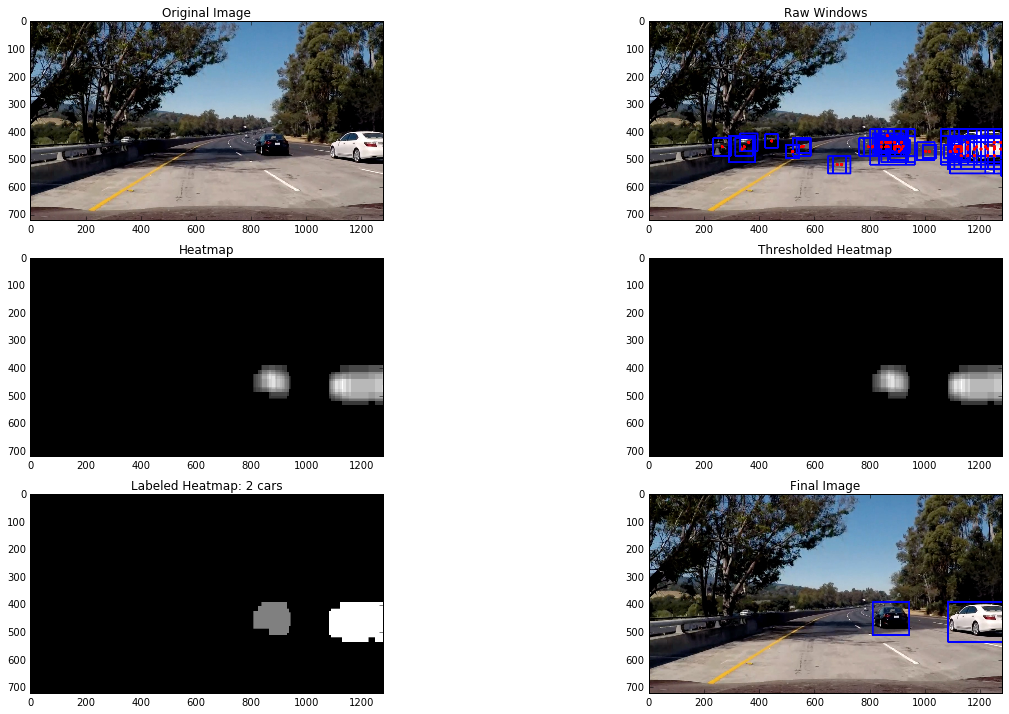

In [43]:
fig = plt.figure(figsize=(20,10))
plt.subplot(321)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(322)
plt.imshow(window_image)
plt.title('Raw Windows')
plt.subplot(323)
m = np.max(heatmap)
plt.imshow(heatmap*(255/m), cmap='gray');
plt.title('Heatmap')
plt.subplot(324)
m = np.max(thresh_heatmap)
plt.imshow(thresh_heatmap*(255/m), cmap='gray');
plt.title('Thresholded Heatmap')
plt.subplot(325)
plt.imshow(labels[0], cmap='gray')
plt.title('Labeled Heatmap: {} cars'.format(labels[1]))
plt.subplot(326)
plt.imshow(annotated_image);
plt.title('Final Image')
fig.tight_layout()

In [44]:
import cProfile, pstats, io

In [45]:
pr = cProfile.Profile()
pr.enable()
annotated_image = vdetector.process_image(img = image, debug=False)
pr.disable()
s = io.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

         307381 function calls in 1.634 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    1.635    0.817 /Users/alexeysimonov/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2855(run_code)
        2    0.000    0.000    1.635    0.817 {built-in method builtins.exec}
        1    0.001    0.001    1.635    1.635 <ipython-input-45-fddc199fc5a5>:3(<module>)
        1    0.009    0.009    1.634    1.634 <ipython-input-39-7ecbbb403762>:85(process_image)
        1    0.016    0.016    1.610    1.610 <ipython-input-34-2f59e463ca94>:3(search_windows)
        1    0.010    0.010    1.494    1.494 <ipython-input-22-d4c7509f2dda>:1(extract_features)
     1142    0.005    0.000    1.029    0.001 <ipython-input-21-eb55bb71bef0>:2(features_hog)
     1142    0.398    0.000    1.023    0.001 /Users/alexeysimonov/anaconda/lib/python3.5/site-packages/skimage/feature/_hog.py:8(hog)
     114

In [46]:
vdetector = VehicleDetector(feature_scaler = feature_scaler, 
                            classifier = classifier, 
                            classifier_input_size = classifier_input_size,
                            decision_function_threshold = decision_function_threshold,
                            heatmap_threshold = heatmap_threshold,
                            colorspace = colorspace, 
                            spatial_size = spatial_size, 
                            hist_bins = hist_bins, 
                            hist_range = hist_range, 
                            hog_orient = hog_orient, 
                            hog_pix_per_cell = hog_pix_per_cell, 
                            hog_cell_per_block = hog_cell_per_block, 
                            hog_channel = hog_channel)

In [47]:
#input_clip = VideoFileClip("project_video.mp4")
#input_clip = VideoFileClip("project_video_annotated.mp4")
input_clip = VideoFileClip("project_video_annotated_short.mp4")
#input_clip = VideoFileClip("project_video_annotated.mp4").subclip(26, 37)

annotated_output = 'project_video_annotated2.mp4'
#annotated_output = 'project_video_annotated_short.mp4'

In [ ]:
#annotated_clip = input_clip

In [48]:
%time annotated_clip = input_clip.fl_image(vdetector.process_image) #NOTE: this function expects color images!!

CPU times: user 1.52 s, sys: 62.5 ms, total: 1.58 s
Wall time: 1.52 s


In [49]:
annotated_clip.write_videofile(annotated_output, audio=False)

[MoviePy] >>>> Building video project_video_annotated2.mp4
[MoviePy] Writing video project_video_annotated2.mp4


100%|█████████▉| 275/276 [06:45<00:01,  1.40s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_annotated2.mp4 



In [50]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(annotated_output))